In [17]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

import numpy as np

import torch
import torch.nn as nn
import torch.utils.data as data
from sklearn import datasets
from torch.autograd import Variable

### Dataset creation

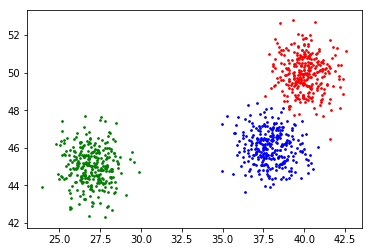

In [18]:
cluster_points = 300

X = np.zeros((3*cluster_points, 2))
y = np.zeros(3*cluster_points)

mean = [(40, 50),
        (27, 45),
        (38, 46)]

cov = [[[1,0], [0, 1]],
       [[1, 0], [0, 1]],
       [[1, 0], [0, 1]]]

colors = ['r', 'g', 'b']

for i, (m, c, color) in enumerate(zip(mean, cov, colors)):
    cluster = np.random.multivariate_normal(m, c, cluster_points)
    plt.scatter(cluster[:, 0], cluster[:, 1], s=3, c=color)
    X[(i*cluster_points):((i+1)*cluster_points), :] = cluster
    y[(i*cluster_points):((i+1)*cluster_points)] = i

plt.show()

In [19]:
X = torch.from_numpy(X.astype('float32'))
y = torch.from_numpy(y.astype('int'))

In [20]:
ds = data.TensorDataset(X, y)
data_loader = data.DataLoader(ds, batch_size=128,
                              shuffle=True,
                              num_workers=4)

### Classifier

In [21]:
class LogReg(nn.Module):
    def __init__(self, in_size, n_classes):
        super(LogReg, self).__init__()
        self.lin = nn.Linear(in_size, n_classes)
        self.bn = nn.BatchNorm1d(n_classes)
        
    def forward(self, X):
        out = self.lin(X)
        out = self.bn(out)
        return out
    
model = LogReg(X.size(1), 3)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [22]:
%%time

n_epochs = 100
accuracies = []

for epoch in range(n_epochs):
    if not (epoch % (n_epochs / 10)):
        print("Epoch {}".format(epoch))
        
    for (X_batch, y_batch) in data_loader:
        X_batch = Variable(X_batch)
        y_batch = Variable(y_batch)
        
        y_pred = model(X_batch)
        loss = loss_func(y_pred, y_batch)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        _, y_pred = torch.max(y_pred, 1)
        acc = torch.sum((y_pred == y_batch).data) / y_pred.size(0)
        accuracies.append(acc)

Epoch 0
Epoch 10
Epoch 20
Epoch 30
Epoch 40
Epoch 50
Epoch 60
Epoch 70
Epoch 80
Epoch 90
CPU times: user 6.65 s, sys: 31.2 s, total: 37.9 s
Wall time: 12.3 s


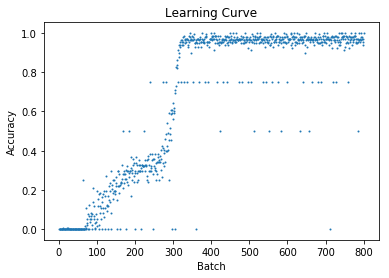

In [ ]:
plt.title("Learning Curve")
plt.xlabel("Batch")
plt.ylabel("Accuracy")
plt.scatter(np.linspace(1, len(accuracies), len(accuracies)), accuracies, s=1)
plt.show()

In [ ]:
model.eval()
y_pred = model(Variable(X))
_, y_pred = torch.max(y_pred, 1)

for x, label in zip(X.numpy(), y_pred.view(-1).data.numpy()):
    plt.scatter(x[0], x[1], s=3, color=colors[label])
    
plt.show()

In [ ]:
model.eval()
y_pred = model(Variable(X))
_, y_pred = torch.max(y_pred, 1)

acc = torch.sum((y_pred == Variable(y)).data) / y_pred.size(0)
print(acc)

### Reference

In [10]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(C=10000, max_iter=n_epochs) #higher C, lesser l2
clf.fit(X.numpy(), y.numpy())
acc = clf.score(X.numpy(), y.numpy())
print(acc)

0.985555555556


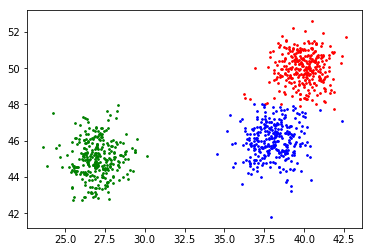

In [11]:
y_pred = clf.predict(X.numpy())

for x, label in zip(X.numpy(), y_pred):
    plt.scatter(x[0], x[1], s=3, color=colors[label])
    
plt.show()